In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scanpy as scר
import pandas as pd
from data_gen import *
from visualizations import *
from datasets import *


In [3]:
import cyclum.tuning
import cyclum.models


In [4]:
adata =  read_all_scn_no_obs()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [6]:
r_genes = ['Bmal1','Dbp','Nr1d1','Per2','Ciart','Nr1d2','Per1','Tef','Ahsa2','Cct8a','Hsp90aa1','Hsp90ab1','Hsph1']
r_genes2 = ['Dbp','Nr1d1','Per2','Ciart','Nr1d2','Per1','Tef','Ahsa2','Hsp90aa1','Hsp90ab1','Hsph1']
type_genes = ['Agt', 'Itm2a','Tmem212','Hexb','Celf4','Pdgfra','Top2a','Plp1','Opalin','Plin3','Tnr','Col23a1','Vip','Avp','Nms','Cck','C1ql3','Grp','Bdnf']
def pre_processes_for_cyclum(adata_tmp, r_genes,type_genes):
    sc.pp.highly_variable_genes(adata_tmp, n_top_genes=3000)#min_mean=0.0125, max_mean=3, min_disp=0.5)
    for gene in r_genes: # Make sure that the rhytmic and type markers are not filtered out
        adata_tmp.var.highly_variable[gene]=True
    for gene in type_genes:
        adata_tmp.var.highly_variable[gene]=True
    adata_tmp = adata_tmp[:, adata_tmp.var.highly_variable]
    return adata_tmp

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CT' as categorical
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ST' as categorical
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remov

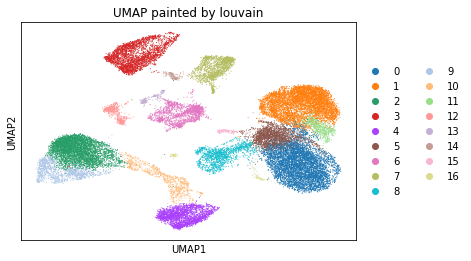

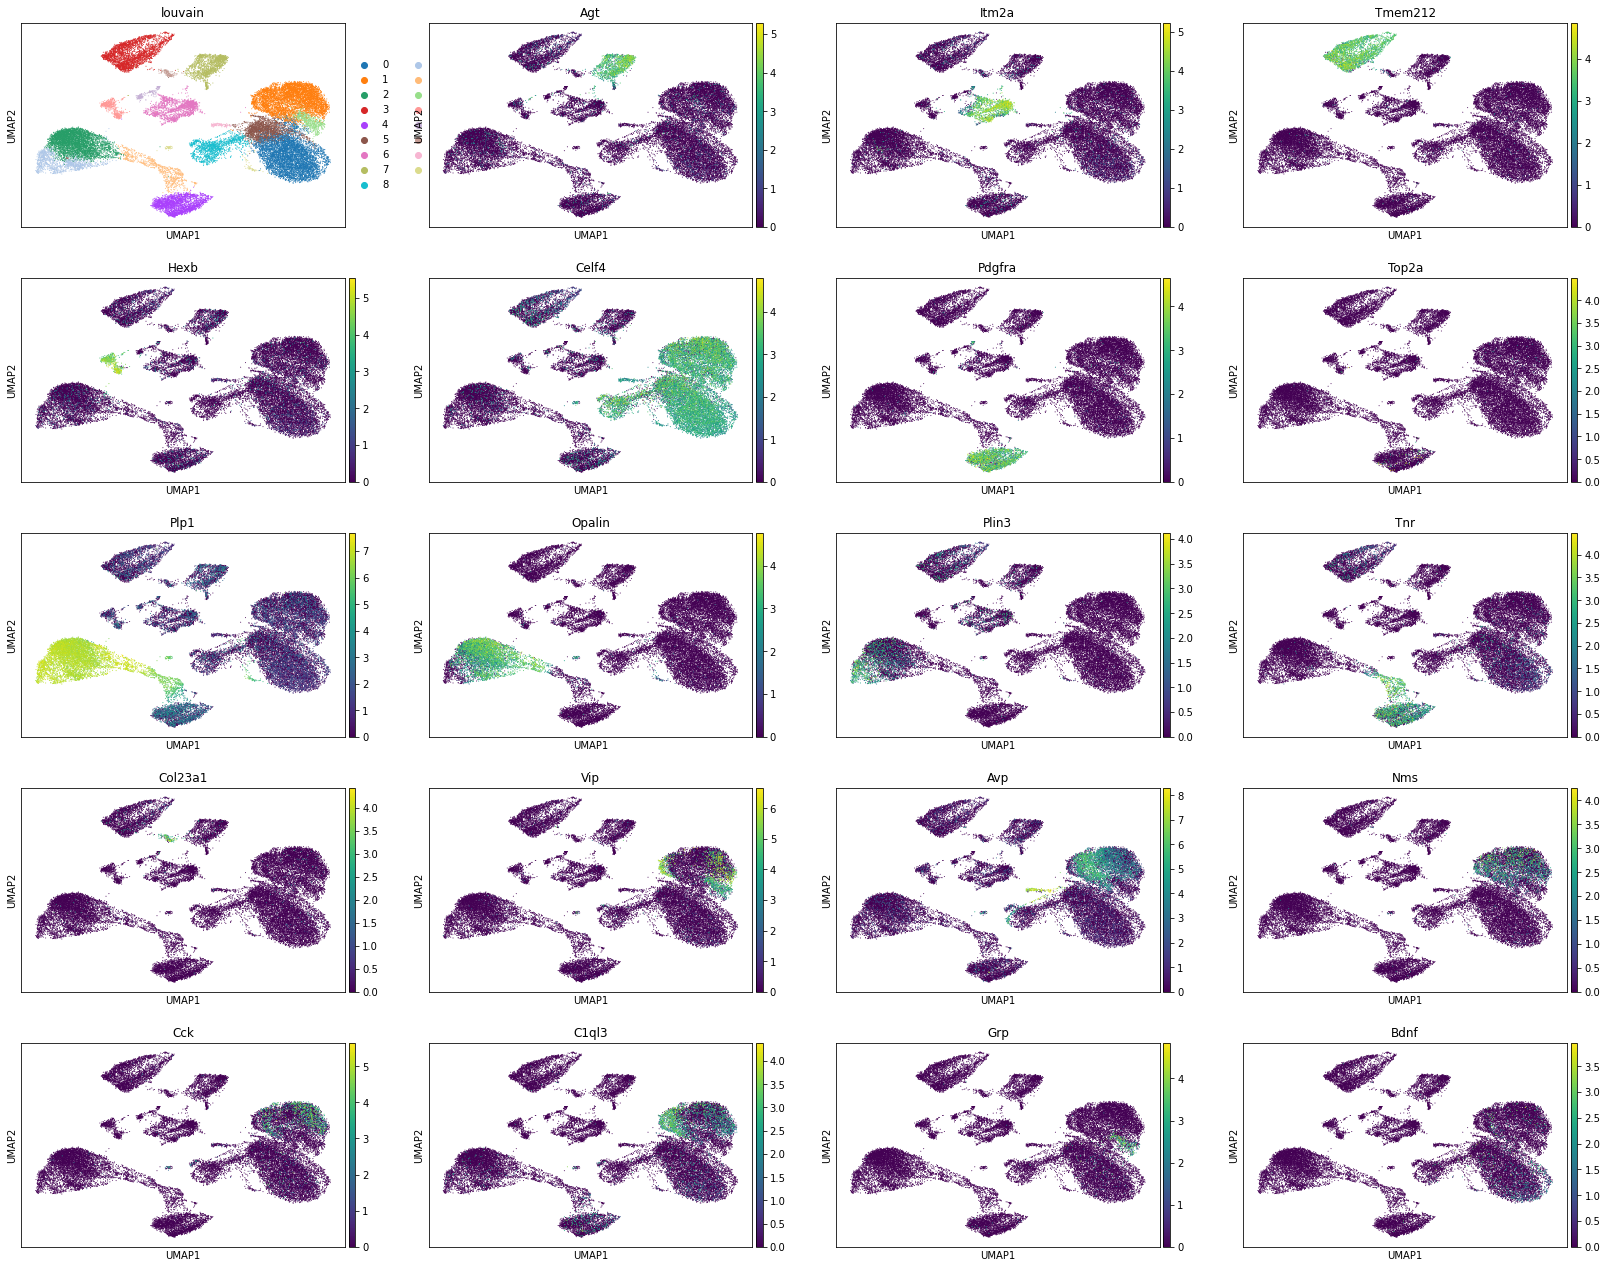

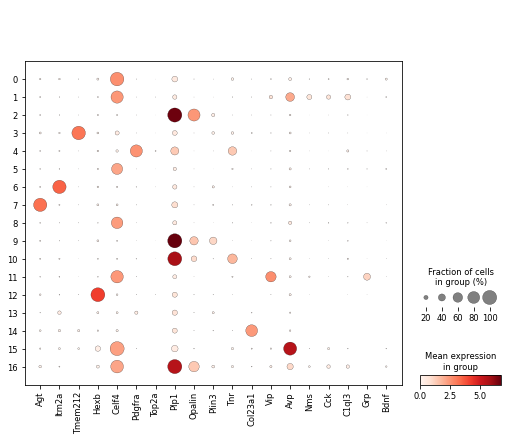

In [7]:


sc.tl.louvain(adata, resolution=0.7)
sc.tl.umap(adata)
sc.pl.umap(adata, color='louvain' , title=("UMAP painted by louvain"))
marker_genes = ['Agt', 'Itm2a','Tmem212','Hexb','Celf4','Pdgfra','Top2a','Plp1','Opalin','Plin3','Tnr','Col23a1','Vip','Avp','Nms','Cck','C1ql3','Grp','Bdnf']
sc.pl.umap(adata, color=['louvain']+marker_genes)
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

In [10]:
new_cluster_names = [
    'Neurons1', 'SCN Neurons','Oligodendrocytes1','Ependymal',
    'NG2','Neurons3','Endothelial', 
    'Astrocytes','Neurons4','Oligodendrocytes2','Oligodendrocytes3',
    'Neurons5','Microglia' ,'not_real','Tanycytes','Neurons6',
    'Neurons7']
adata.rename_categories('louvain', new_cluster_names)


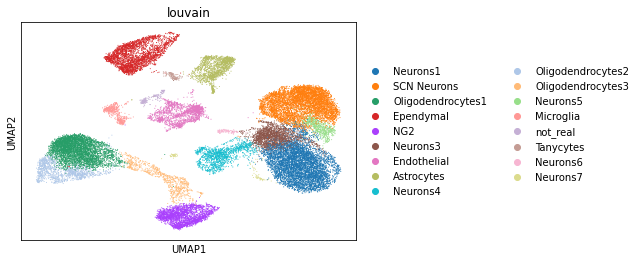

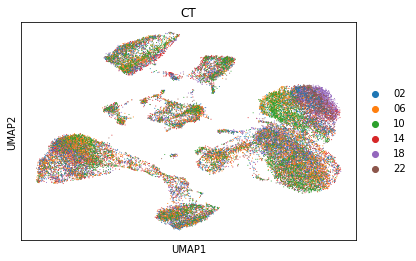

In [11]:
sc.pl.umap(adata, color=['louvain'])
sc.pl.umap(adata, color=['CT'])
orig_adata = adata.copy()


In [12]:
adata = adata[adata.obs['louvain'].isin(['Astrocytes'])]
adata = pre_processes_for_cyclum(adata,r_genes,type_genes)
cluster='Astrocytes'
adata.write("SCN/" + cluster+"_raw_cyclum" +".h5ad")
model = cyclum.tuning.CyclumAutoTune(adata.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model.train(adata.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime = model.predict_pseudotime(adata.X)
circular_comp = model.get_circular_component(pseudotime)


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...


2022-09-12 11:40:42.457353: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


epoch: 100/500, loss:  0.2005, time elapsed:  8.54s, time left:  34.15s
epoch: 200/500, loss:  0.1856, time elapsed:  17.76s, time left:  26.63s
epoch: 300/500, loss:  0.1797, time elapsed:  27.12s, time left:  18.08s
epoch: 400/500, loss:  0.1782, time elapsed:  37.09s, time left:  9.27s
epoch: 500/500, loss:  0.1761, time elapsed:  47.41s, time left:  0.00s
[0.17614585161209106]
[0.24833381, 0.24526623, 0.24351119, 0.24192423, 0.24084862, 0.23980142, 0.23887591, 0.23799834, 0.2371524, 0.23633361, 0.23552723, 0.23474428]
    1 linear dimensions...
epoch: 100/500, loss:  0.1730, time elapsed:  11.45s, time left:  45.81s
epoch: 200/500, loss:  0.1719, time elapsed:  24.62s, time left:  36.93s
epoch: 300/500, loss:  0.1717, time elapsed:  36.95s, time left:  24.64s
epoch: 400/500, loss:  0.1716, time elapsed:  48.52s, time left:  12.13s
epoch: 500/500, loss:  0.1716, time elapsed:  59.87s, time left:  0.00s
[0.17614585161209106, 0.1716153621673584]
[0.24833381, 0.24526623, 0.24351119, 0.

In [13]:
flat_embedding = (pseudotime % (2 * np.pi)) / 2
flat_embedding = flat_embedding[:,0]
sort = np.argsort(flat_embedding)
bdata = adata.copy()
bdata = bdata[sort,:]


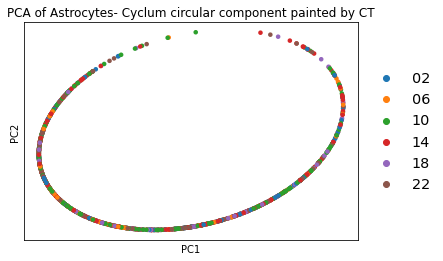

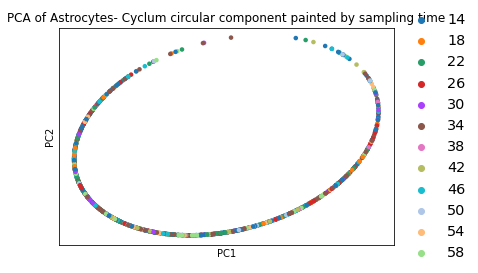

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


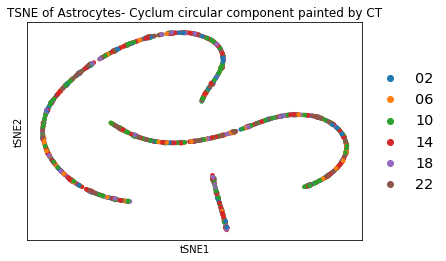

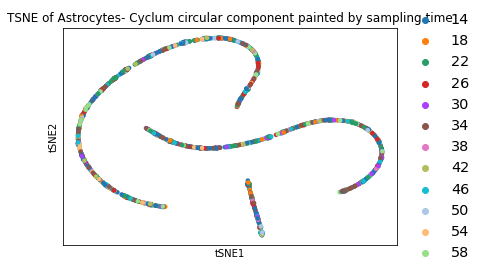

In [14]:
adata_circular = bdata.copy()
adata_circular.X = circular_comp
all_plots_scn(adata_circular,title= "Astrocytes- Cyclum circular component" )
cluster='Astrocytes'
adata_circular.write("SCN/" + cluster+"_en_cyclum" +".h5ad")


/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.


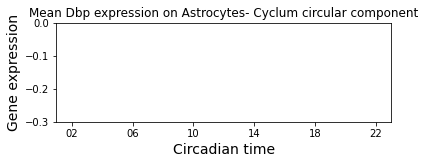

In [15]:
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular[adata_circular.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.3, 0])
plt.title("Mean "+ gene + " expression on Astrocytes- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/500, loss:  0.2039, time elapsed:  13.19s, time left:  52.76s
epoch: 200/500, loss:  0.1907, time elapsed:  27.35s, time left:  41.02s
epoch: 300/500, loss:  0.1833, time elapsed:  47.50s, time left:  31.67s
epoch: 400/500, loss:  0.1814, time elapsed:  73.34s, time left:  18.33s
epoch: 500/500, loss:  0.1811, time elapsed:  103.12s, time left:  0.00s
[0.18107832968235016]
[0.25223103, 0.24725366, 0.24384892, 0.24231121, 0.24097553, 0.23981991, 0.23877895, 0.23783995, 0.23693062, 0.23605776, 0.2352239, 0.2344224]
    1 linear dimensions...
epoch: 100/500, loss:  0.1798, time elapsed:  22.67s, time left:  90.69s
epoch: 200/500, loss:  0.1789, time elapsed:  38.84s, time left:  58.26s
epoch: 300/500, loss:  0.1781, time elapsed:  62.35s, time left:  41.57s
epoch: 400/500, loss:  0.1765, time elapsed:  87.18s, time left:  21.79s
epoch: 500/500, loss:  0.1763, tim

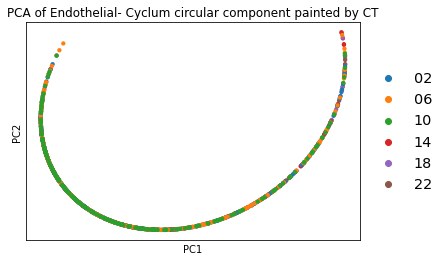

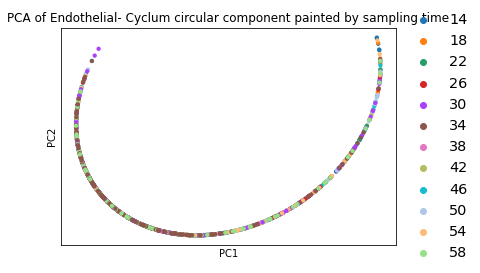

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


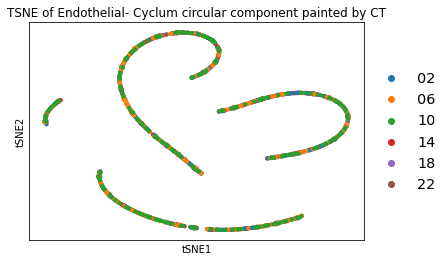

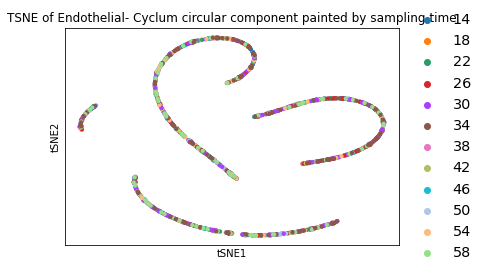

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.


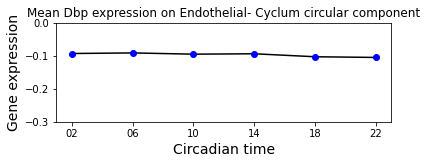

In [16]:
adata2 = orig_adata[orig_adata.obs['louvain'].isin(['Endothelial'])]
adata2 = pre_processes_for_cyclum(adata2,r_genes,type_genes)
cluster='Endothelial'
adata2.write("SCN/" + cluster+"_raw_cyclum" +".h5ad")

model2 = cyclum.tuning.CyclumAutoTune(adata2.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model2.train(adata2.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime2 = model2.predict_pseudotime(adata2.X)
circular_comp2 = model2.get_circular_component(pseudotime2)
adata_circular2 = adata2.copy()
adata_circular2.X = circular_comp2
all_plots_scn(adata_circular2,title= "Endothelial- Cyclum circular component" )
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular2[adata_circular2.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.3, 0])
plt.title("Mean "+ gene + " expression on Endothelial- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


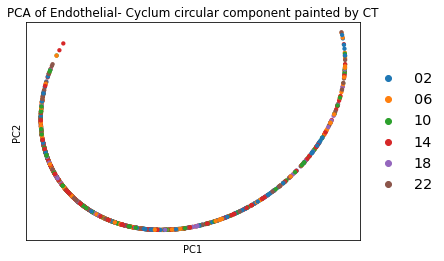

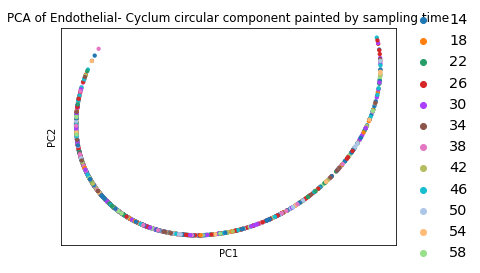

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


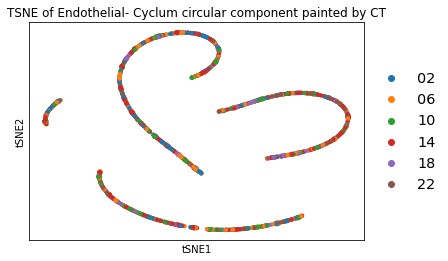

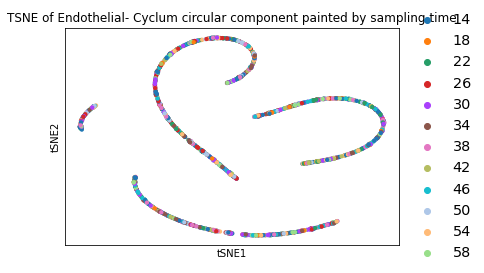

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.


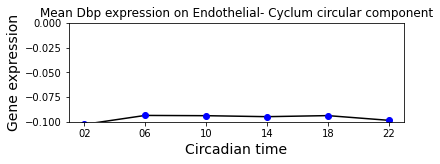

In [17]:
flat_embedding2 = (pseudotime2 % (2 * np.pi)) / 2
flat_embedding2 = flat_embedding2[:,0]
sort2 = np.argsort(flat_embedding2)
bdata2 = adata2.copy()
bdata2 = bdata2[sort2,:]
adata_circular2 = bdata2.copy()
adata_circular2.X = circular_comp2
cluster='Endothelial'
adata_circular2.write("SCN/" + cluster+"_en_cyclum" +".h5ad")
all_plots_scn(adata_circular2,title= "Endothelial- Cyclum circular component" )
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular2[adata_circular2.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.1, 0])
plt.title("Mean "+ gene + " expression on Endothelial- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.


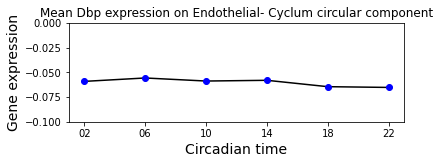

In [18]:
adata3 = orig_adata[orig_adata.obs['louvain'].isin(['Ependymal'])]
cluster='Ependymal'
adata3.write("SCN/" + cluster+"_raw_cyclum" +".h5ad")
adata3 = pre_processes_for_cyclum(adata3,r_genes,type_genes)
model3 = cyclum.tuning.CyclumAutoTune(adata3.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model3.train(adata3.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime3 = model3.predict_pseudotime(adata3.X)
circular_comp3 = model3.get_circular_component(pseudotime3)


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/500, loss:  0.2224, time elapsed:  23.09s, time left:  92.35s
epoch: 200/500, loss:  0.2110, time elapsed:  47.73s, time left:  71.60s
epoch: 300/500, loss:  0.2070, time elapsed:  71.88s, time left:  47.92s
epoch: 400/500, loss:  0.2066, time elapsed:  95.53s, time left:  23.88s
epoch: 500/500, loss:  0.2066, time elapsed:  119.17s, time left:  0.00s
[0.20655255019664764]
[0.31425363, 0.31103638, 0.3099561, 0.3089119, 0.30809426, 0.30730116, 0.30655694, 0.30583254, 0.30512962, 0.30444297, 0.30377272, 0.30311665]
    1 linear dimensions...
epoch: 100/500, loss:  0.2042, time elapsed:  24.26s, time left:  97.05s
epoch: 200/500, loss:  0.2039, time elapsed:  47.80s, time left:  71.70s
epoch: 300/500, loss:  0.2037, time elapsed:  71.56s, time left:  47.71s
epoch: 400/500, loss:  0.2036, time elapsed:  99.86s, time left:  24.97s
epoch: 500/500, loss:  0.2034, tim

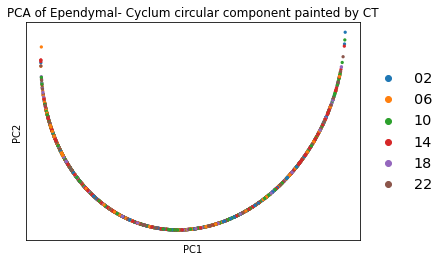

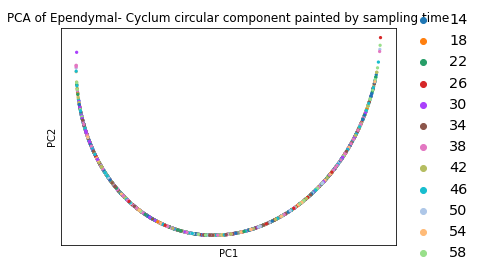

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


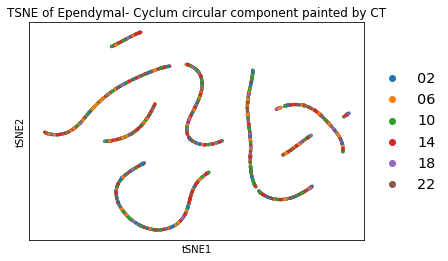

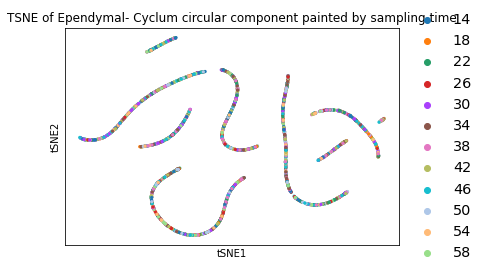

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.


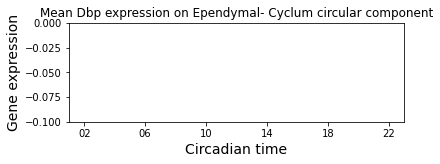

In [19]:
flat_embedding3 = (pseudotime3 % (2 * np.pi)) / 2
flat_embedding3 = flat_embedding3[:,0]
sort3= np.argsort(flat_embedding3)
bdata3 = adata3.copy()
bdata3 = bdata3[sort3,:]
adata_circular3 = bdata3.copy()
adata_circular3.X = circular_comp3
cluster='Ependymal'
adata_circular3.write("SCN/" + cluster+"_en_cyclum" +".h5ad")
all_plots_scn(adata_circular3,title= "Ependymal- Cyclum circular component" )
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular3[adata_circular3.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.1, 0])
plt.title("Mean "+ gene + " expression on Ependymal- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


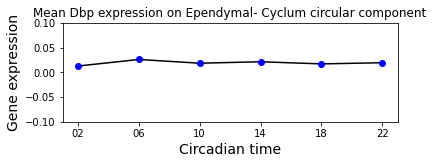

In [24]:
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.1, 0.1])
plt.title("Mean "+ gene + " expression on Ependymal- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


In [26]:
adata4 = orig_adata[orig_adata.obs['louvain'].isin(['Microglia'])]
cluster='Microglia'
adata4.write("SCN/" + cluster+"_raw_cyclum" +".h5ad")
adata4 = pre_processes_for_cyclum(adata4,r_genes,type_genes)
model4 = cyclum.tuning.CyclumAutoTune(adata4.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model4.train(adata4.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime4 = model4.predict_pseudotime(adata4.X)
circular_comp4 = model4.get_circular_component(pseudotime4)


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/500, loss:  0.2726, time elapsed:  10.79s, time left:  43.17s
epoch: 200/500, loss:  0.2566, time elapsed:  19.84s, time left:  29.76s
epoch: 300/500, loss:  0.2466, time elapsed:  28.88s, time left:  19.26s
epoch: 400/500, loss:  0.2390, time elapsed:  38.06s, time left:  9.51s
epoch: 500/500, loss:  0.2324, time elapsed:  47.32s, time left:  0.00s
[0.2324267476797104]
[0.29846063, 0.29545352, 0.2931573, 0.29135123, 0.289627, 0.28814447, 0.28672522, 0.28536516, 0.2840103, 0.2827049, 0.28141794, 0.2801703]
    1 linear dimensions...
epoch: 100/500, loss:  0.2142, time elapsed:  10.89s, time left:  43.58s
epoch: 200/500, loss:  0.2110, time elapsed:  20.19s, time left:  30.28s
epoch: 300/500, loss:  0.2096, time elapsed:  29.48s, time left:  19.65s
epoch: 400/500, loss:  0.2088, time elapsed:  38.87s, time left:  9.72s
epoch: 500/500, loss:  0.2085, time elapse

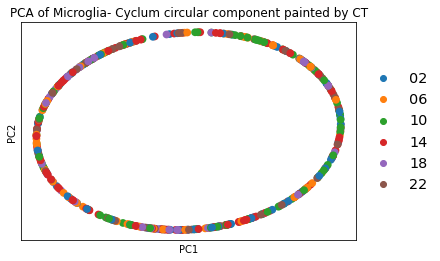

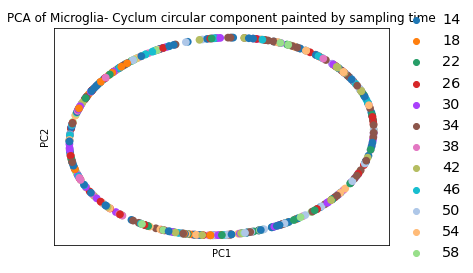

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


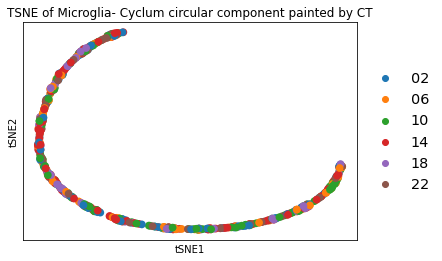

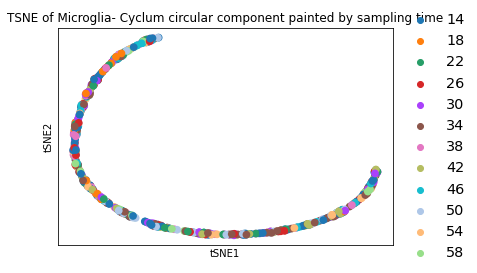

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.


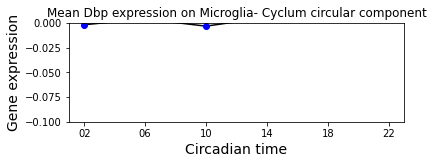

In [27]:
flat_embedding4 = (pseudotime4 % (2 * np.pi)) / 2
flat_embedding4 = flat_embedding4[:,0]
sort4= np.argsort(flat_embedding4)
bdata4 = adata4.copy()
bdata4 = bdata4[sort4,:]
adata_circular4 = bdata4.copy()
adata_circular4.X = circular_comp4
cluster='Microglia'
adata_circular4.write("SCN/" + cluster+"_en_cyclum" +".h5ad")
all_plots_scn(adata_circular4,title= "Microglia- Cyclum circular component" )
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular4[adata_circular4.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.1, 0])
plt.title("Mean "+ gene + " expression on Microglia- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/500, loss:  0.2017, time elapsed:  46.76s, time left:  187.05s
epoch: 200/500, loss:  0.1948, time elapsed:  90.57s, time left:  135.86s
epoch: 300/500, loss:  0.1929, time elapsed:  134.20s, time left:  89.47s
epoch: 400/500, loss:  0.1927, time elapsed:  177.97s, time left:  44.49s
epoch: 500/500, loss:  0.1927, time elapsed:  221.39s, time left:  0.00s
[0.1927030235528946]
[0.25655836, 0.2548907, 0.25341558, 0.2524175, 0.25149485, 0.25057876, 0.24971513, 0.24889226, 0.24809085, 0.24730337, 0.24652502, 0.24576117]
    1 linear dimensions...
epoch: 100/500, loss:  0.1912, time elapsed:  47.37s, time left:  189.49s
epoch: 200/500, loss:  0.1909, time elapsed:  93.29s, time left:  139.93s
epoch: 300/500, loss:  0.1908, time elapsed:  139.52s, time left:  93.01s
epoch: 400/500, loss:  0.1908, time elapsed:  192.78s, time left:  48.20s
epoch: 500/500, loss:  0.19

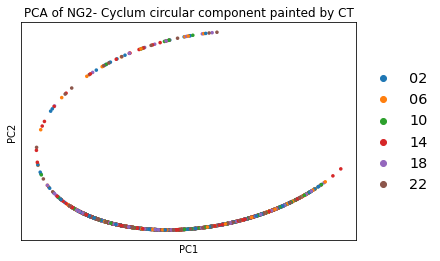

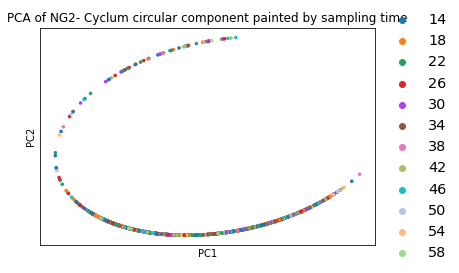

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


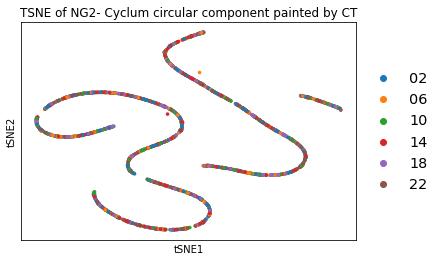

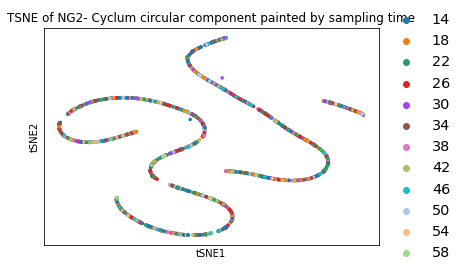

IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (2362,) while AnnData index has shape (499,).

In [28]:
adata5 = orig_adata[orig_adata.obs['louvain'].isin(['NG2'])]
cluster='NG2'
adata5.write("SCN/" + cluster+"_raw_cyclum" +".h5ad")
adata5 = pre_processes_for_cyclum(adata5,r_genes,type_genes)
model5 = cyclum.tuning.CyclumAutoTune(adata5.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model5.train(adata5.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime5 = model5.predict_pseudotime(adata5.X)
circular_comp5 = model5.get_circular_component(pseudotime5)
flat_embedding5 = (pseudotime5 % (2 * np.pi)) / 2
flat_embedding5 = flat_embedding5[:,0]
sort5= np.argsort(flat_embedding5)
bdata5 = adata5.copy()
bdata5 = bdata5[sort5,:]
adata_circular5 = bdata5.copy()
adata_circular5.X = circular_comp5
cluster='NG2'
adata_circular5.write("SCN/" + cluster+"_en_cyclum" +".h5ad")
all_plots_scn(adata_circular5,title= "NG2- Cyclum circular component" )
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular4[adata_circular5.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.1, 0])
plt.title("Mean "+ gene + " expression on Microglia- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/500, loss:  0.1705, time elapsed:  66.51s, time left:  266.05s
epoch: 200/500, loss:  0.1686, time elapsed:  117.68s, time left:  176.53s
epoch: 300/500, loss:  0.1683, time elapsed:  198.26s, time left:  132.17s
epoch: 400/500, loss:  0.1680, time elapsed:  466.91s, time left:  116.73s
epoch: 500/500, loss:  0.1679, time elapsed:  573.61s, time left:  0.00s
[0.16789256036281586]
[0.24566545, 0.24315779, 0.2411389, 0.23931687, 0.23767975, 0.23646052, 0.23551601, 0.23465694, 0.23386754, 0.2331182, 0.23241836, 0.2317494]
    1 linear dimensions...
epoch: 100/500, loss:  0.1660, time elapsed:  100.94s, time left:  403.76s
epoch: 200/500, loss:  0.1658, time elapsed:  190.86s, time left:  286.30s
epoch: 300/500, loss:  0.1658, time elapsed:  311.52s, time left:  207.68s
epoch: 400/500, loss:  0.1656, time elapsed:  515.82s, time left:  128.96s
epoch: 500/500, loss

epoch: 1000/1000, loss:  0.1542, time elapsed:  1413.40s, time left:  0.00s


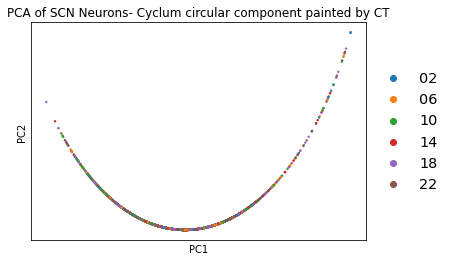

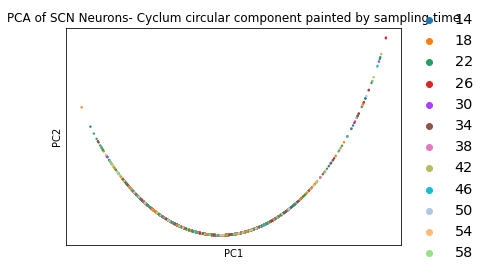

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


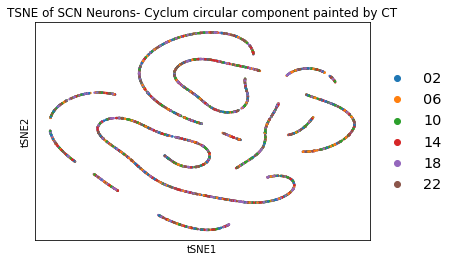

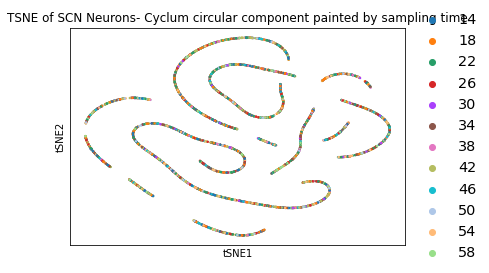

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.


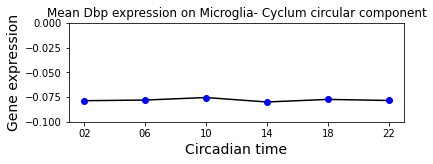

In [29]:
adata6 = orig_adata[orig_adata.obs['louvain'].isin(['SCN Neurons'])]
cluster='SCN Neurons'
adata6.write("SCN/" + cluster+"_raw_cyclum" +".h5ad")
adata6 = pre_processes_for_cyclum(adata6,r_genes,type_genes)
model6 = cyclum.tuning.CyclumAutoTune(adata6.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model6.train(adata6.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime6 = model6.predict_pseudotime(adata6.X)
circular_comp6 = model6.get_circular_component(pseudotime6)
flat_embedding6 = (pseudotime6 % (2 * np.pi)) / 2
flat_embedding6 = flat_embedding6[:,0]
sort6= np.argsort(flat_embedding6)
bdata6 = adata6.copy()
bdata6 = bdata6[sort6,:]
adata_circular6 = bdata6.copy()
adata_circular6.X = circular_comp6
cluster='SCN Neurons'
adata_circular6.write("SCN/" + cluster+"_en_cyclum" +".h5ad")
all_plots_scn(adata_circular6,title= "SCN Neurons- Cyclum circular component" )
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular6[adata_circular6.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.1, 0])
plt.title("Mean "+ gene + " expression on Microglia- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/500, loss:  0.1199, time elapsed:  172.51s, time left:  690.04s
epoch: 200/500, loss:  0.1178, time elapsed:  935.79s, time left:  1403.69s
epoch: 300/500, loss:  0.1177, time elapsed:  3038.90s, time left:  2025.93s
epoch: 400/500, loss:  0.1177, time elapsed:  6340.25s, time left:  1585.06s
epoch: 500/500, loss:  0.1176, time elapsed:  6891.24s, time left:  0.00s
[0.11763276904821396]
[0.21517287, 0.21176772, 0.20929664, 0.20721367, 0.2059521, 0.20489535, 0.20398197, 0.20316868, 0.20241377, 0.20179743, 0.20120914, 0.20066683]
    1 linear dimensions...
epoch: 100/500, loss:  0.1141, time elapsed:  594.97s, time left:  2379.90s
epoch: 200/500, loss:  0.1139, time elapsed:  3413.57s, time left:  5120.36s
epoch: 300/500, loss:  0.1139, time elapsed:  3528.57s, time left:  2352.38s
epoch: 400/500, loss:  0.1139, time elapsed:  3664.79s, time left:  916.20s
epoch

epoch: 1000/1000, loss:  0.1032, time elapsed:  1830.01s, time left:  0.00s


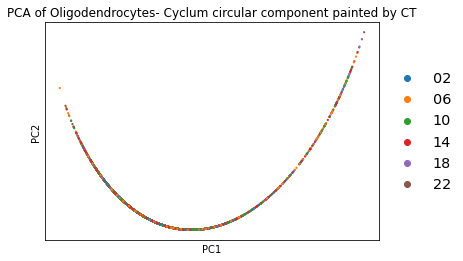

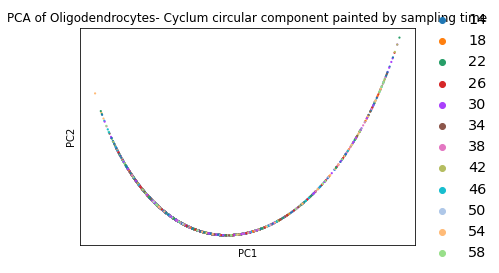

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


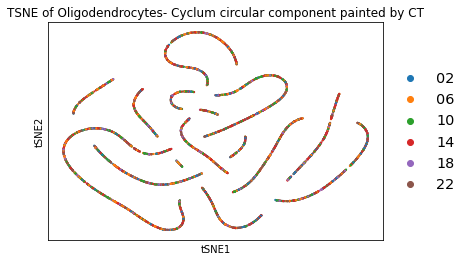

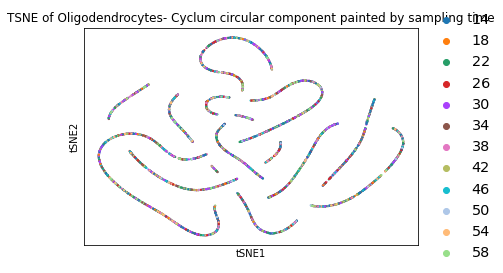

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.


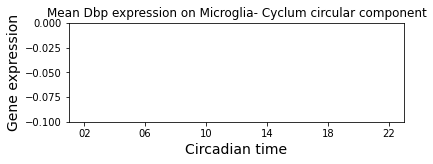

In [30]:
adata7 = orig_adata[orig_adata.obs['louvain'].isin(['Oligodendrocytes1','Oligodendrocytes2','Oligodendrocytes3'])]
cluster='Oligodendrocytes'
adata7.write("SCN/" + cluster+"_raw_cyclum" +".h5ad")
adata7 = pre_processes_for_cyclum(adata7,r_genes,type_genes)
model7 = cyclum.tuning.CyclumAutoTune(adata7.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model7.train(adata7.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime7 = model7.predict_pseudotime(adata7.X)
circular_comp7 = model7.get_circular_component(pseudotime7)
flat_embedding7 = (pseudotime7 % (2 * np.pi)) / 2
flat_embedding7 = flat_embedding7[:,0]
sort7= np.argsort(flat_embedding7)
bdata7 = adata7.copy()
bdata7 = bdata7[sort7,:]
adata_circular7 = bdata7.copy()
adata_circular7.X = circular_comp7
cluster='Oligodendrocytes'
adata_circular7.write("SCN/" + cluster+"_en_cyclum" +".h5ad")
all_plots_scn(adata_circular7,title= "Oligodendrocytes- Cyclum circular component" )
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular7[adata_circular7.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.1, 0])
plt.title("Mean "+ gene + " expression on Microglia- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()


Trying to set attribute `._uns` of view, copying.
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/500, loss:  0.3572, time elapsed:  9.16s, time left:  36.65s
epoch: 200/500, loss:  0.3435, time elapsed:  13.24s, time left:  19.85s
epoch: 300/500, loss:  0.3340, time elapsed:  18.76s, time left:  12.51s
epoch: 400/500, loss:  0.3270, time elapsed:  23.86s, time left:  5.96s
epoch: 500/500, loss:  0.3215, time elapsed:  28.67s, time left:  0.00s
[0.32146501541137695]
[0.36700475, 0.36135238, 0.3571126, 0.35317728, 0.3492767, 0.34545702, 0.3416761, 0.33792886, 0.33429942, 0.33074883, 0.32723004, 0.32381868]
    1 linear dimensions...
epoch: 100/500, loss:  0.2877, time elapsed:  9.10s, time left:  36.41s
epoch: 200/500, loss:  0.2790, time elapsed:  14.26s, time left:  21.40s
epoch: 300/500, loss:  0.2767, time elapsed:  19.58s, time left:  13.06s
epoch: 400/500, loss:  0.2752, time elapsed:  24.85s, time left:  6.21s
epoch: 500/500, loss:  0.2742, time elap

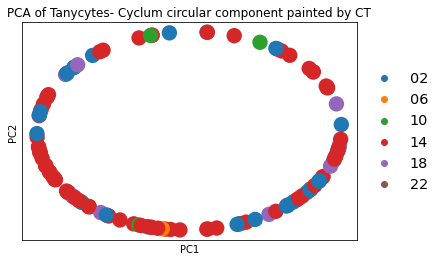

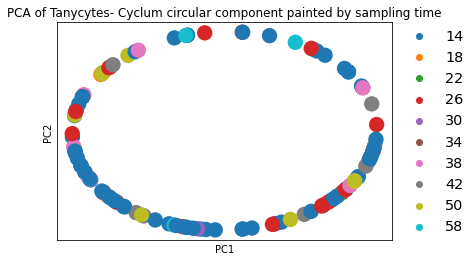

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


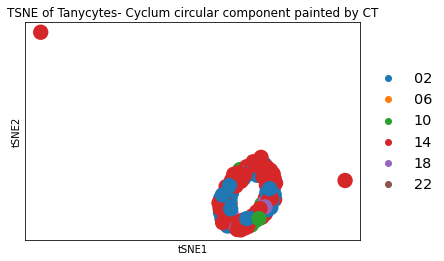

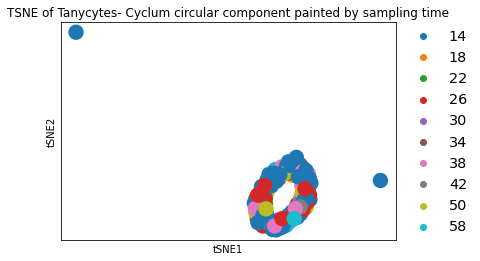

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.


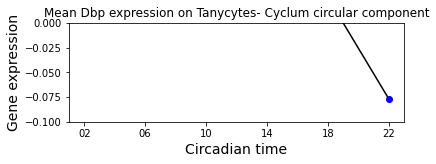

In [31]:
adata8 = orig_adata[orig_adata.obs['louvain'].isin(['Tanycytes'])]
cluster='Tanycytes'
adata8.write("SCN/" + cluster+"_raw_cyclum" +".h5ad")
adata8 = pre_processes_for_cyclum(adata8,r_genes,type_genes)
model8 = cyclum.tuning.CyclumAutoTune(adata8.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model8.train(adata8.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime8 = model8.predict_pseudotime(adata8.X)
circular_comp8 = model8.get_circular_component(pseudotime8)
flat_embedding8 = (pseudotime8 % (2 * np.pi)) / 2
flat_embedding8 = flat_embedding8[:,0]
sort8= np.argsort(flat_embedding8)
bdata8 = adata8.copy()
bdata8 = bdata8[sort8,:]
adata_circular8 = bdata8.copy()
adata_circular8.X = circular_comp8
cluster='Tanycytes'
adata_circular8.write("SCN/" + cluster+"_en_cyclum" +".h5ad")
all_plots_scn(adata_circular8,title= "Tanycytes- Cyclum circular component" )
gene = 'Dbp'
ct_list = ['02', '06', '10', '14', '18', '22']
e_array = np.zeros(6)
for i, ct in enumerate(ct_list):
        adata_nr = (adata_circular8[adata_circular8.obs['CT'].isin([ct])])
        e_array[i] = float(np.mean(adata_nr[:, gene].X))
plt.figure()
plt.subplot(211)
plt.plot(ct_list, e_array, 'k')
plt.plot(ct_list, e_array, 'bo', color='b')  # ct_list, dbp_array, 'k')
plt.ylim([-0.1, 0])
plt.title("Mean "+ gene + " expression on Tanycytes- Cyclum circular component")
plt.ylabel("Gene expression", fontsize=14)
plt.xlabel("Circadian time" , fontsize=14)
plt.show()
